### Thesis notebook 4.3. - NOVA IMS

#### LSTM - Temporal data representation

In this notebook, we will finally start our application of temporal representation using LSTMs and bi-directional LSTMs.
The argument for the usage of Deep Learning stems from the fact that sequences themselves encode information that can be extracted using Recurrent Neural Networks and, more specifically, Long Short Term Memory Units.

#### First Step: Setup a PyTorch environment that enables the use of GPU for training. 

The following cell wll confirm that the GPU will be the default device to use.

In [14]:
import torch
import pycuda.driver as cuda

cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU

#set all tensors to gpu
torch.set_default_tensor_type('torch.cuda.FloatTensor')

#### Second Step: Import the relevant packages and declare global variables

In [15]:
#import necessary modules/libraries
import numpy as np
import scipy
import pandas as pd
import datetime as dt
import warnings
import time

#tqdm to monitor progress
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

#time related features
from datetime import timedelta
from copy import copy, deepcopy

#vizualization
import matplotlib.pyplot as plt
import seaborn as sns

#imblearn, scalers, kfold and metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer,PowerTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, recall_score, classification_report, average_precision_score, precision_recall_curve

#import torch related
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable 
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


#and optimizer of learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau

#import pytorch modules
warnings.filterwarnings('ignore')

In [16]:
#global variables that may come in handy
#course threshold sets the % duration that will be considered (1 = 100%)
duration_threshold = [0.1, 0.25, 0.33, 0.5, 1]

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

#Function designed to deal with multiindex and flatten it
def flattenHierarchicalCol(col,sep = '_'):
    '''converts multiindex columns into single index columns while retaining the hierarchical components'''
    if not type(col) is tuple:
        return col
    else:
        new_col = ''
        for leveli,level in enumerate(col):
            if not level == '':
                if not leveli == 0:
                    new_col += sep
                new_col += level
        return new_col
    
#number of replicas - number of repeats of stratified k fold - in this case 10
replicas = 1

#names to display on result figures
date_names = {
             'Date_threshold_10': '10% of Course Duration',   
             'Date_threshold_25': '25% of Course Duration', 
             'Date_threshold_33': '33% of Course Duration', 
             'Date_threshold_50': '50% of Course Duration', 
             'Date_threshold_100':'100% of Course Duration', 
            }

target_names = {
                'exam_fail' : 'At risk - Exam Grade',
                'final_fail' : 'At risk - Final Grade', 
                'exam_gifted' : 'High performer - Exam Grade', 
                'final_gifted': 'High performer - Final Grade'
                }

#targets
targets = ['exam_fail' , 'final_fail' , 'exam_gifted' , 'final_gifted']
temporal_columns = ['0 to 4%', '4 to 8%', '8 to 12%', '12 to 16%', '16 to 20%', '20 to 24%',
       '24 to 28%', '28 to 32%', '32 to 36%', '36 to 40%', '40 to 44%',
       '44 to 48%', '48 to 52%', '52 to 56%', '56 to 60%', '60 to 64%',
       '64 to 68%', '68 to 72%', '72 to 76%', '76 to 80%', '80 to 84%',
       '84 to 88%', '88 to 92%', '92 to 96%', '96 to 100%']

#### Step 3: Import data and take a preliminary look at it 

In [17]:
#imports dataframes
course_programs = pd.read_excel("../Data/Modeling Stage/Nova_IMS_Temporal_Datasets_25_splits.xlsx", 
                                dtype = {
                                    'course_encoding' : int,
                                    'userid' : int},
                               sheet_name = None)

#save tables 
student_list = pd.read_csv('../Data/Modeling Stage/Nova_IMS_Filtered_targets.csv', 
                         dtype = {
                                   'course_encoding': int,
                                   'userid' : int,
                                   })

#drop unnamed 0 column
for i in course_programs:
        
    #merge with the targets we calculated on the other 
    course_programs[i] = course_programs[i].merge(student_list, on = ['course_encoding', 'userid'], how = 'inner')
    course_programs[i].drop(['Unnamed: 0', 'exam_mark', 'final_mark'], axis = 1, inplace = True)
    
    #convert results to object
    course_programs[i]['course_encoding'], course_programs[i]['userid'] = course_programs[i]['course_encoding'].astype(object), course_programs[i]['userid'].astype(object)

In [18]:
course_programs['Date_threshold_100'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9296 entries, 0 to 9295
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   course_encoding  9296 non-null   object
 1   userid           9296 non-null   object
 2   0 to 4%          9296 non-null   int64 
 3   4 to 8%          9296 non-null   int64 
 4   8 to 12%         9296 non-null   int64 
 5   12 to 16%        9296 non-null   int64 
 6   16 to 20%        9296 non-null   int64 
 7   20 to 24%        9296 non-null   int64 
 8   24 to 28%        9296 non-null   int64 
 9   28 to 32%        9296 non-null   int64 
 10  32 to 36%        9296 non-null   int64 
 11  36 to 40%        9296 non-null   int64 
 12  40 to 44%        9296 non-null   int64 
 13  44 to 48%        9296 non-null   int64 
 14  48 to 52%        9296 non-null   int64 
 15  52 to 56%        9296 non-null   int64 
 16  56 to 60%        9296 non-null   int64 
 17  60 to 64%        9296 non-null   

In [19]:
course_programs['Date_threshold_100'].describe(include = 'all')

,course_encoding,userid,0 to 4%,4 to 8%,8 to 12%,12 to 16%,16 to 20%,20 to 24%,24 to 28%,28 to 32%,...,76 to 80%,80 to 84%,84 to 88%,88 to 92%,92 to 96%,96 to 100%,exam_fail,final_fail,exam_gifted,final_gifted
count,9296.0,9296.0,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,...,9296.000000,9296.000000,9296.000000,9296.000000,9296.000000,9296.0,9296.000000,9296.000000,9296.000000,9296.000000
unique,138.0,1590.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,150.0,3178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,178.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.081863,8.307874,10.752797,11.193739,10.127797,8.966652,10.545396,11.445245,...,11.718051,13.136403,22.827883,27.341007,12.599613,0.0,0.201377,0.149957,0.276893,0.308090
std,NaN,NaN,3.526351,13.580025,13.626754,16.400023,14.291254,12.180177,13.507892,15.932226,...,28.186874,36.690068,47.158607,54.963959,35.194597,0.0,0.401051,0.357048,0.447487,0.461729
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,1.000000,2.000000,2.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,2.000000,7.000000,7.000000,6.000000,5.000000,7.000000,7.000000,...,2.000000,2.000000,4.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,1.000000,12.000000,15.000000,15.000000,13.000000,13.000000,14.000000,14.000000,...,10.000000,10.000000,23.000000,27.000000,5.000000,0.0,0.000000,0.000000,1.000000,1.000000


In our first attempt, we will use the absolute number of clicks made by each student - scaled using standard scaler. 
Therefore, we can start by immediately placing our course encoding/userid pairings into the index.

In [20]:
#function for scalers
def normalize(dataset,scaler):
    
    if scaler == 'MinMax':
        pt = MinMaxScaler()
    elif scaler == 'Standard':
        pt = StandardScaler()
    elif scaler == 'Robust':
        pt = RobustScaler()
    elif scaler == 'Quantile':
        pt = QuantileTransformer()
    else:
        pt = PowerTransformer(method='yeo-johnson')
    
    data = pt.fit_transform(dataset)
    
    # convert the array back to a dataframe
    normalized_df = pd.DataFrame(data,columns=dataset.columns)
    return normalized_df  

In [21]:
#create backup
normalized_data = deepcopy(course_programs)

#convert index
for i in tqdm(normalized_data):
    normalized_data[i].set_index(['course_encoding', 'userid'], drop = True, inplace = True)
    normalized_data[i].fillna(0, inplace = True)
    #Then, apply normalize function to rescale the train columns
    normalized_data[i] = normalize(normalized_data[i].filter(temporal_columns),'Standard')
    
    #and remerge target columns
    normalized_data[i][targets] =  deepcopy(course_programs[i][targets])

  0%|          | 0/5 [00:00<?, ?it/s]

#### Implementing Cross-Validation with Deep Learning Model

1. Start with creating the Train-test Split and make the necessary conversions to torch tensor.

In this instance, we will follow-up with on the approach used in Chen & Cui - CrossEntropyLoss with applied over a softmax layer.

In [22]:
test = deepcopy(normalized_data['Date_threshold_100'])

#set X and Y columns
X = test[test.columns[:25]] #different timesteps
y = test[test.columns[-4:]] #the 4 different putative targets


#Start with train test split
X_train_val, X_test, y_train_val, y_test, = train_test_split(
                                    X,
                                   y['exam_fail'], #replace when going for multi-target 
                                   test_size = 0.20,
                                   random_state = 15,
                                   shuffle=True,
                                   stratify = y['exam_fail'] #replace when going for multi-target
                                    )

#Oversampling with SMOTE
over = SMOTE()
X_train_val, y_train_val = over.fit_resample(X_train_val, y_train_val)

# ##second, convert everything to pytorch tensor - we will convert to tensor dataset and 
X_train_tensors = Variable(torch.Tensor(X_train_val.values))
X_test_tensors = Variable(torch.Tensor(X_test.values))

y_train_tensors = Variable(torch.Tensor(y_train_val.values))
y_test_tensors = Variable(torch.Tensor(y_test.values)) 

#now, we have a dataset with features
print('Before reshaping:')
print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors.shape, y_test_tensors.shape)

#reshaping to rows, timestamps, features 
X_train_tensors = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], X_train_tensors.shape[1], 1))
X_test_tensors = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], X_test_tensors.shape[1], 1))

# y_train_tensors = y_train_tensors[:, None]
# y_test_tensors = y_test_tensors[:, None]

#repeat for y
y_train_tensors = y_train_tensors.type(torch.cuda.LongTensor)
y_test_tensors = y_test_tensors.type(torch.cuda.LongTensor)

print('\nAfter reshaping:')
print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors.shape, y_test_tensors.shape)

#create dataset
dataset = TensorDataset(X_train_tensors, y_train_tensors)

Before reshaping:
Training Shape torch.Size([11878, 25]) torch.Size([11878])
Testing Shape torch.Size([1860, 25]) torch.Size([1860])

After reshaping:
Training Shape torch.Size([11878, 25, 1]) torch.Size([11878])
Testing Shape torch.Size([1860, 25, 1]) torch.Size([1860])


**2. Create the Deep Learning Model**

In [23]:
class LSTM_Uni(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM_Uni, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first = True) #lstm
        
        self.dropout = nn.Dropout(p = 0.5)
    
        self.fc = nn.Linear(self.hidden_size, num_classes) #fully connected last layer

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        lstm_out, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state

        last_output = lstm_out[:, -1]
        #we are interested in only keeping the last output
        drop_out = self.dropout(last_output)
        pre_softmax = self.fc(drop_out) #Final Output - dense
        return pre_softmax

**3. Define the train and validation Functions**

In [24]:
def train_epoch(model,dataloader,loss_fn,optimizer):
    
    train_loss,train_correct=0.0,0 
    model.train()
    for X, labels in dataloader:

        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
        scores, predictions = torch.max(F.log_softmax(output.data), 1)
        train_correct += (predictions == labels).sum().item()
        
    return train_loss,train_correct
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for X, labels in dataloader:

        output = model(X)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*X.size(0)
        scores, predictions = torch.max(F.log_softmax(output.data), 1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct 

**4. Define main hyperparameters of the model, including splits**

In [25]:
#Model
num_epochs = 50 #100 epochs
learning_rate = 0.002 #0.002 lr
input_size = 1 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

#Shape of Output as required for Binary Cross Entropy
num_classes = 2 #output shape

batch_size = 2

k=10
splits= KFold(n_splits=k,shuffle=True,random_state=15)
foldperf={}
criterion = nn.CrossEntropyLoss()    # cross-entropy for classification

**5. Initialize Model and Train with Cross-Validation**

In [26]:
best_accuracy = 0
for fold, (train_idx,val_idx) in tqdm(enumerate(splits.split(np.arange(len(dataset))))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    
    #creates new model for each 
    model = LSTM_Uni(num_classes, input_size, hidden_size, num_layers, X_train_tensors.shape[1]).to('cuda') #our lstm class
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    scheduler = ReduceLROnPlateau(optimizer, 
                                  'min', 
                                  patience = 10,
                                  cooldown = 10,
                                 verbose = True)
    
    history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}

    for epoch in tqdm(range(num_epochs)):
        train_loss, train_correct=train_epoch(model,train_loader,criterion,optimizer)
        val_loss, val_correct=valid_epoch(model,val_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        val_loss = val_loss / len(val_loader.sampler)
        val_acc = val_correct / len(val_loader.sampler) * 100
        
        
        if (epoch+1) % 10 == 0: 
            print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Validation Loss:{:.3f} AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             val_loss,
                                                                                                             train_acc,
                                                                                                             val_acc))
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        scheduler.step(val_loss)
    
        if val_acc > best_accuracy:
            
            #replace best accuracy and save best model
            print(f'New Best Accuracy found: {val_acc:.2f}%\nEpoch: {epoch + 1}')
            best_accuracy = val_acc
            best = deepcopy(model)
    
    foldperf['fold{}'.format(fold+1)] = history  

#torch.save(best,f"../Models/{i}/Nova_IMS_best_{epochs}_epochs_{k}.h")

0it [00:00, ?it/s]

Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

New Best Accuracy found: 59.01%
Epoch: 0
New Best Accuracy found: 62.21%
Epoch: 1
New Best Accuracy found: 63.22%
Epoch: 2
New Best Accuracy found: 67.51%
Epoch: 3
New Best Accuracy found: 69.70%
Epoch: 4
New Best Accuracy found: 70.62%
Epoch: 6
New Best Accuracy found: 71.30%
Epoch: 7
New Best Accuracy found: 72.22%
Epoch: 8
Epoch:10/50 AVG Training Loss:0.520 AVG Validation Loss:0.541 AVG Training Acc 73.26 % AVG Validation Acc 71.89 %
New Best Accuracy found: 72.73%
Epoch: 10
New Best Accuracy found: 73.74%
Epoch: 11
New Best Accuracy found: 74.58%
Epoch: 12
New Best Accuracy found: 75.17%
Epoch: 13
Epoch:20/50 AVG Training Loss:0.403 AVG Validation Loss:0.543 AVG Training Acc 81.64 % AVG Validation Acc 75.25 %
New Best Accuracy found: 75.25%
Epoch: 19
New Best Accuracy found: 76.01%
Epoch: 20
New Best Accuracy found: 76.60%
Epoch: 21
New Best Accuracy found: 78.37%
Epoch: 27
New Best Accuracy found: 78.62%
Epoch: 28
Epoch:30/50 AVG Training Loss:0.327 AVG Validation Loss:0.519 AVG 

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:10/50 AVG Training Loss:0.525 AVG Validation Loss:0.543 AVG Training Acc 73.72 % AVG Validation Acc 71.38 %
Epoch:20/50 AVG Training Loss:0.406 AVG Validation Loss:0.497 AVG Training Acc 81.80 % AVG Validation Acc 76.18 %
Epoch:30/50 AVG Training Loss:0.336 AVG Validation Loss:0.531 AVG Training Acc 85.69 % AVG Validation Acc 76.77 %
Epoch    35: reducing learning rate of group 0 to 2.0000e-04.
Epoch:40/50 AVG Training Loss:0.145 AVG Validation Loss:0.606 AVG Training Acc 94.66 % AVG Validation Acc 80.72 %
New Best Accuracy found: 81.82%
Epoch: 42
Epoch:50/50 AVG Training Loss:0.076 AVG Validation Loss:0.841 AVG Training Acc 97.70 % AVG Validation Acc 80.98 %
Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:10/50 AVG Training Loss:0.550 AVG Validation Loss:0.580 AVG Training Acc 71.45 % AVG Validation Acc 68.60 %
Epoch:20/50 AVG Training Loss:0.431 AVG Validation Loss:0.581 AVG Training Acc 79.97 % AVG Validation Acc 73.57 %
Epoch:30/50 AVG Training Loss:0.375 AVG Validation Loss:0.536 AVG Training Acc 83.14 % AVG Validation Acc 76.18 %
Epoch    35: reducing learning rate of group 0 to 2.0000e-04.
Epoch:40/50 AVG Training Loss:0.186 AVG Validation Loss:0.628 AVG Training Acc 92.36 % AVG Validation Acc 79.80 %
Epoch:50/50 AVG Training Loss:0.119 AVG Validation Loss:0.812 AVG Training Acc 95.60 % AVG Validation Acc 79.38 %
Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:10/50 AVG Training Loss:0.566 AVG Validation Loss:0.555 AVG Training Acc 70.17 % AVG Validation Acc 69.70 %
Epoch:20/50 AVG Training Loss:0.448 AVG Validation Loss:0.490 AVG Training Acc 78.32 % AVG Validation Acc 76.18 %
Epoch:30/50 AVG Training Loss:0.369 AVG Validation Loss:0.512 AVG Training Acc 83.32 % AVG Validation Acc 77.69 %
Epoch    31: reducing learning rate of group 0 to 2.0000e-04.
Epoch:40/50 AVG Training Loss:0.190 AVG Validation Loss:0.607 AVG Training Acc 92.16 % AVG Validation Acc 80.64 %
Epoch:50/50 AVG Training Loss:0.144 AVG Validation Loss:0.736 AVG Training Acc 94.26 % AVG Validation Acc 81.90 %
New Best Accuracy found: 81.90%
Epoch: 49
Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:10/50 AVG Training Loss:0.520 AVG Validation Loss:0.552 AVG Training Acc 74.18 % AVG Validation Acc 72.05 %
Epoch:20/50 AVG Training Loss:0.398 AVG Validation Loss:0.523 AVG Training Acc 82.25 % AVG Validation Acc 75.34 %
Epoch:30/50 AVG Training Loss:0.328 AVG Validation Loss:0.539 AVG Training Acc 86.55 % AVG Validation Acc 75.67 %
Epoch:40/50 AVG Training Loss:0.283 AVG Validation Loss:0.541 AVG Training Acc 88.56 % AVG Validation Acc 77.44 %
Epoch    49: reducing learning rate of group 0 to 2.0000e-04.
Epoch:50/50 AVG Training Loss:0.172 AVG Validation Loss:0.567 AVG Training Acc 93.76 % AVG Validation Acc 79.88 %
Fold 6


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:10/50 AVG Training Loss:0.561 AVG Validation Loss:0.562 AVG Training Acc 71.08 % AVG Validation Acc 70.62 %
Epoch:20/50 AVG Training Loss:0.457 AVG Validation Loss:0.535 AVG Training Acc 77.90 % AVG Validation Acc 74.07 %
Epoch:30/50 AVG Training Loss:0.391 AVG Validation Loss:0.533 AVG Training Acc 81.49 % AVG Validation Acc 76.18 %
Epoch:40/50 AVG Training Loss:0.344 AVG Validation Loss:0.553 AVG Training Acc 84.85 % AVG Validation Acc 75.93 %
Epoch    43: reducing learning rate of group 0 to 2.0000e-04.
Epoch:50/50 AVG Training Loss:0.166 AVG Validation Loss:0.596 AVG Training Acc 93.20 % AVG Validation Acc 79.97 %
Fold 7


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:10/50 AVG Training Loss:0.545 AVG Validation Loss:0.556 AVG Training Acc 72.01 % AVG Validation Acc 71.46 %
Epoch:20/50 AVG Training Loss:0.450 AVG Validation Loss:0.566 AVG Training Acc 78.78 % AVG Validation Acc 72.31 %
Epoch    26: reducing learning rate of group 0 to 2.0000e-04.
Epoch:30/50 AVG Training Loss:0.259 AVG Validation Loss:0.555 AVG Training Acc 89.15 % AVG Validation Acc 78.96 %
Epoch:40/50 AVG Training Loss:0.184 AVG Validation Loss:0.689 AVG Training Acc 92.79 % AVG Validation Acc 79.46 %
Epoch    47: reducing learning rate of group 0 to 2.0000e-05.
Epoch:50/50 AVG Training Loss:0.132 AVG Validation Loss:0.885 AVG Training Acc 95.38 % AVG Validation Acc 78.20 %
Fold 8


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:10/50 AVG Training Loss:0.561 AVG Validation Loss:0.564 AVG Training Acc 71.19 % AVG Validation Acc 70.29 %
Epoch:20/50 AVG Training Loss:0.447 AVG Validation Loss:0.521 AVG Training Acc 78.83 % AVG Validation Acc 74.92 %
Epoch:30/50 AVG Training Loss:0.355 AVG Validation Loss:0.490 AVG Training Acc 84.01 % AVG Validation Acc 76.94 %
Epoch:40/50 AVG Training Loss:0.313 AVG Validation Loss:0.524 AVG Training Acc 86.56 % AVG Validation Acc 78.20 %
Epoch    49: reducing learning rate of group 0 to 2.0000e-04.
Epoch:50/50 AVG Training Loss:0.222 AVG Validation Loss:0.532 AVG Training Acc 91.38 % AVG Validation Acc 80.22 %
Fold 9


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:10/50 AVG Training Loss:0.547 AVG Validation Loss:0.559 AVG Training Acc 71.61 % AVG Validation Acc 71.44 %
Epoch:20/50 AVG Training Loss:0.399 AVG Validation Loss:0.516 AVG Training Acc 81.72 % AVG Validation Acc 76.66 %
Epoch:30/50 AVG Training Loss:0.332 AVG Validation Loss:0.508 AVG Training Acc 85.76 % AVG Validation Acc 78.43 %
Epoch    35: reducing learning rate of group 0 to 2.0000e-04.
New Best Accuracy found: 81.97%
Epoch: 37
New Best Accuracy found: 82.48%
Epoch: 38
Epoch:40/50 AVG Training Loss:0.145 AVG Validation Loss:0.560 AVG Training Acc 94.72 % AVG Validation Acc 82.31 %
New Best Accuracy found: 82.73%
Epoch: 48
Epoch:50/50 AVG Training Loss:0.086 AVG Validation Loss:0.716 AVG Training Acc 97.25 % AVG Validation Acc 82.90 %
New Best Accuracy found: 82.90%
Epoch: 49
Fold 10


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:10/50 AVG Training Loss:0.535 AVG Validation Loss:0.566 AVG Training Acc 72.49 % AVG Validation Acc 71.02 %
Epoch:20/50 AVG Training Loss:0.419 AVG Validation Loss:0.532 AVG Training Acc 80.97 % AVG Validation Acc 73.46 %
Epoch:30/50 AVG Training Loss:0.353 AVG Validation Loss:0.518 AVG Training Acc 84.90 % AVG Validation Acc 75.91 %
Epoch:40/50 AVG Training Loss:0.296 AVG Validation Loss:0.565 AVG Training Acc 87.87 % AVG Validation Acc 75.48 %
Epoch    43: reducing learning rate of group 0 to 2.0000e-04.
Epoch:50/50 AVG Training Loss:0.121 AVG Validation Loss:0.699 AVG Training Acc 95.61 % AVG Validation Acc 79.70 %


In [33]:
val_f,tl_f,vala_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):

    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    val_f.append(np.mean(foldperf['fold{}'.format(f)]['val_loss']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
    vala_f.append(np.mean(foldperf['fold{}'.format(f)]['val_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \nAverage Validation Loss: {:.3f}\nAverage Training Acc: {:.2f} \nAverage Validation Acc: {:.2f}".format(np.mean(tl_f),np.mean(val_f),np.mean(ta_f),np.mean(vala_f)))  

Performance of 10 fold cross validation
Average Training Loss: 0.388 
Average Validation Loss: 0.573
Average Training Acc: 81.18 
Average Validation Acc: 74.61


#### Defining the LSTM Model:

In [34]:
diz_ep = {'train_loss_ep':[],'val_loss_ep':[],'train_acc_ep':[],'val_acc_ep':[]}

for i in range(num_epochs):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_loss'][i] for f in range(k)]))
    diz_ep['val_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['val_loss'][i] for f in range(k)]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_acc'][i] for f in range(k)]))
    diz_ep['val_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['val_acc'][i] for f in range(k)]))

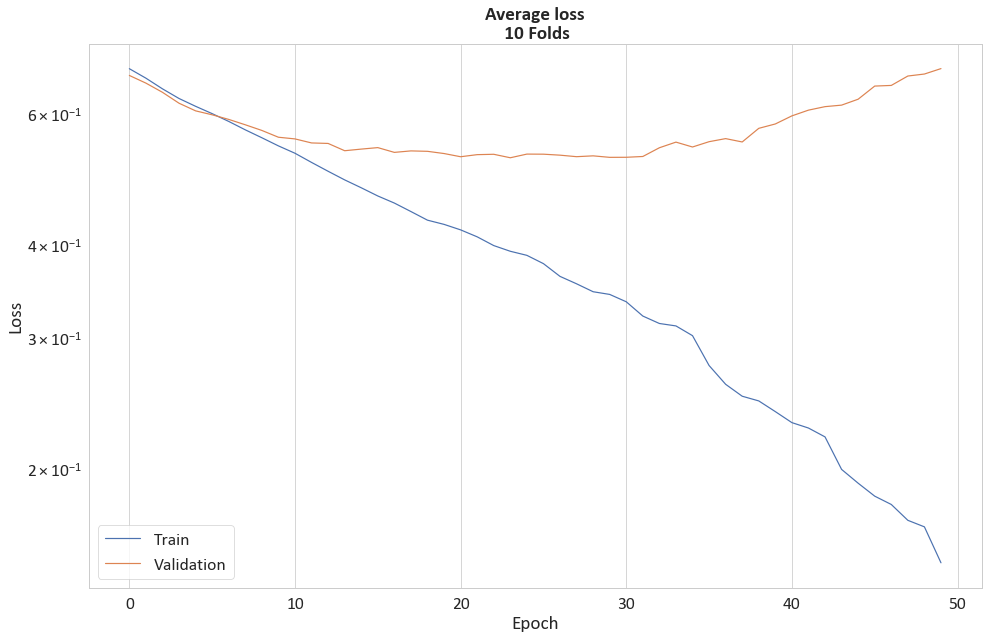

In [35]:
# Plot losses
sns.set_theme(context='paper', style='whitegrid', rc={"figure.figsize":(16, 10)}, font='Calibri', font_scale=2)
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['val_loss_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title(f'Average loss\n {k} Folds', fontweight = 'bold')
plt.show()

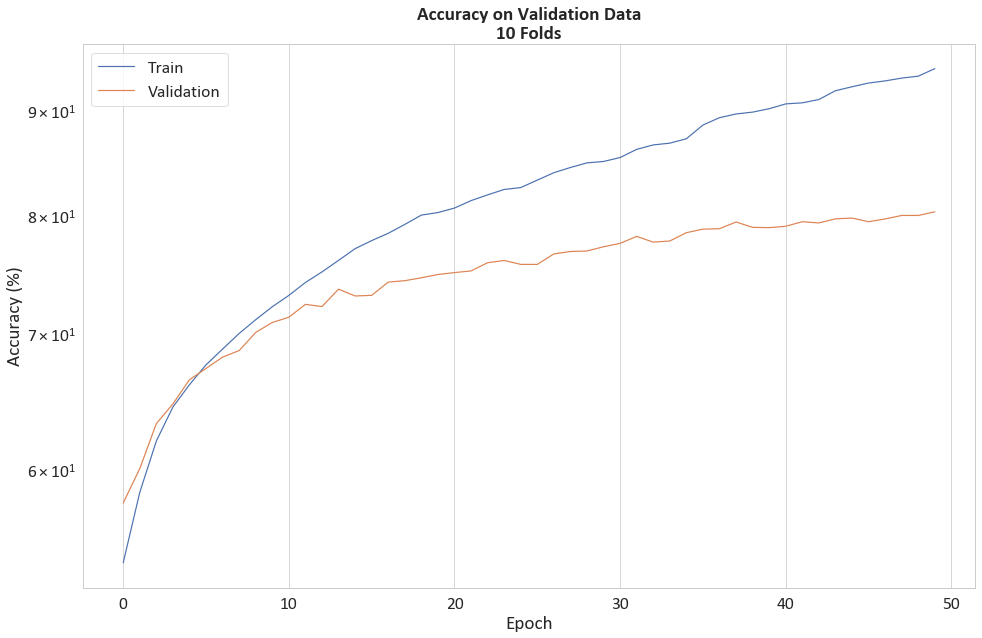

In [36]:
# Plot accuracies
sns.set_theme(context='paper', style='whitegrid', rc={"figure.figsize":(16, 10)}, font='Calibri', font_scale=2)
plt.figure()
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['val_acc_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
#plt.grid()
plt.legend()
plt.title(f'Accuracy on Validation Data\n{k} Folds', fontweight = 'bold')
plt.show()

#### Obtaining results on test data:

In [37]:
_, data_predict = torch.max(F.log_softmax(best(X_test_tensors)), 1) #forward pass with calculation of correct class

data_predict = data_predict.data.cpu().numpy()
dataY_plot = y_test_tensors.data.cpu().numpy()

print(classification_report(dataY_plot, data_predict))
print(confusion_matrix(dataY_plot, data_predict))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1485
           1       0.36      0.51      0.42       375

    accuracy                           0.72      1860
   macro avg       0.61      0.64      0.62      1860
weighted avg       0.76      0.72      0.74      1860

[[1147  338]
 [ 185  190]]


In [38]:
recall_score(dataY_plot, data_predict)

0.5066666666666667

In [39]:
precision_score(dataY_plot, data_predict)

0.35984848484848486

In [40]:
roc_auc_score(dataY_plot, data_predict)

0.6395286195286196

In [44]:
plot_roc_pr(best, X_test_tensors, dataY_plot, 'a.png', 'b.png', '100%', 'exam_fail')

TypeError: 'LSTM_Uni' object is not iterable

In [ ]:
# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    # Loop over batches in an epoch using DataLoader
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        
        y_batch_pred = lstm_uni(x_batch)

        loss = criterion(y_batch_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
    # Every 100 epochs, print the loss for this batch
        # as well as the number of examples processed so far 
#         if id_batch % 100 == 0:
#             loss, current = loss.item(), (id_batch + 1)* len(x_batch)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{dataset_size:>5d}]")



The following cells can be treated as training cells, to be used to understand the pytorch arquitecture.

In [ ]:
data_predict

In [ ]:
F.softmax(lstm_uni(X_test_tensors))

In [ ]:
lstm_uni(X_test_tensors)

In [ ]:
data_predict

#### Step 4: Define functions: 

1. Data Scaling,
2. Data training
3. Obtention of Results and Figures

In [ ]:
rnn = nn.RNN(input_size=i_size, hidden_size=h_size, num_layers = 1, batch_first=True)

In [ ]:
#run desired model
def run_model(model_name, X, y):
    
    ###STANDALONE MODELS
        ###Baseline Classifier - most frequent class
    if model_name == 'Baseline - Majority Class':
        model = DummyClassifier(strategy="most_frequent").fit(X, y)
    if model_name == 'LSTM':
        '''insert code for LSTM classifier'''
    if model_name == 'Bi-directional LSTM':
        '''insert code for Bi directional - LSTM classifier'''
    return model

In [ ]:
#averages scores of each run (for the present model) in each iteration of Repeated 10-fold CV that has been called
def avg_score(method,X,y, model_name):
    
    f1micro_train = []
    f1micro_val = []
    precision_train = []
    precision_val = []
    recall_train = []
    recall_val = []
    timer = []
    cm_holder = []
    test_holder = []
    averaged_confusion_matrix=None
    
    for train_index, val_index in method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        begin = time.perf_counter()
        model = run_model(model_name, X_train, y_train)
        end = time.perf_counter()
        
        labels_train = model.predict(X_train)
        labels_val = model.predict(X_val)
        
        f1micro_train.append(f1_score(y_train, labels_train, average='micro'))
        f1micro_val.append(f1_score(y_val, labels_val, average='micro'))
        
        precision_train.append(precision_score(y_train, labels_train))
        precision_val.append(precision_score(y_val, labels_val))
        
        recall_train.append(recall_score(y_train, labels_train))
        recall_val.append(recall_score(y_val, labels_val))
        
        timer.append(end-begin)
        
        cm_holder.append(confusion_matrix(y_val, labels_val))
        
    model = run_model(model_name, X,y)
    labels_test = model.predict(X_test)
    
    f1micro_test = f1_score(y_test, labels_test, average='micro')
    precision_test = precision_score(y_test, labels_test)
    recall_test = recall_score(y_test, labels_test)
    print(f'Classification Report for {model_name}:\nTest Data\n{classification_report(y_test, labels_test)}\n\n')
    
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_f1_train = round(np.mean(f1micro_train),3)
    avg_f1_val = round(np.mean(f1micro_val),3)
    avg_f1_test = round(np.mean(f1micro_test),3)
    avg_precision_train = round(np.mean(precision_train),3)
    avg_precision_val = round(np.mean(precision_val),3)
    avg_precision_test = round(precision_test,3)
    avg_recall_train = round(np.mean(recall_train),3)
    avg_recall_val = round(np.mean(recall_val),3)
    avg_recall_test = round(recall_test,3)
    
    std_time = round(np.std(timer),3)
    std_f1_train = round(np.std(f1micro_train),3)
    std_f1_val = round(np.std(f1micro_test),3)
    std_precision_train = round(np.std(precision_train),3)
    std_precision_val = round(np.std(precision_val),3)
    std_recall_train = round(np.std(recall_train),3)
    std_recall_val = round(np.std(recall_val),3)
    
    averaged_confusion_matrix = np.mean(cm_holder, axis = 0).round(2)
    
    #from sklearn.metrics import cohen_kappa_score
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_f1_train) + '+/-' + str(std_f1_train), str(avg_f1_val) + '+/-' + str(std_f1_val), str(avg_f1_test), str(avg_precision_train) + '+/-' + str(std_precision_train), str(avg_precision_val) + '+/-' + str(std_precision_val), str(avg_precision_test), str(avg_recall_train) + '+/-' + str(std_recall_train), str(avg_recall_val) + '+/-' + str(std_recall_val), str(avg_recall_test), averaged_confusion_matrix

In [ ]:
def plt_bar(models, f1micro_train, f1micro_val, f1micro_test, path, date, target):
    
    sns.set_theme(context='paper', style='whitegrid', font='Calibri', font_scale=2)
    
    #Creates a figure and a set of subplots
    fig, ax = plt.subplots(figsize = (20, 12))

    #set width of bar
    barwidth = 0.3

    #set position of bar on X axis
    pos_train = np.arange(len(f1micro_test))
    pos_val = np.arange(len(f1micro_test))+0.3
    pos_test = np.arange(len(f1micro_test))+0.6
    
    #convert to number
    f1micro_train = [float(i.split('+')[0]) for i in f1micro_train]
    f1micro_val = [float(i.split('+')[0]) for i in f1micro_val]
    f1micro_test = [float(i.split('+')[0]) for i in f1micro_test]
    
    #makes the plot
    plt.bar(pos_train, f1micro_train, color= nova_ims_colors[0], width=barwidth, edgecolor='white', label='Train')
    plt.bar(pos_val, f1micro_val, color=course_color, width=barwidth, edgecolor='white', label='Validation')
    plt.bar(pos_test, f1micro_test, color=student_color, width=barwidth, edgecolor='white', label='Test')
    
    #sets x, y labels
    ax.set(xlabel = 'Model', ylabel = 'Accuracy')

    #sets x ticks locations and designation
    ax.set_xticks((pos_train+pos_val+pos_test)/3)
    ax.set_xticklabels(models, rotation='vertical')
    
    #ads title to the plot
    plt.title(f'10-fold Repeated Cross-Validation Results\nData: {date}, Target:{target}', fontweight="bold")
    plt.ylim([0.0, 1.05])
    #removes box to make the plot prettier
    plt.box(on=None)

    #Creates (pretty) legend
    plt.legend(frameon=False)
    
    plt.savefig(path, transparent=True, dpi=300)
    plt.close("all")

In [43]:
def plot_roc_pr(models, X, y, path_roc, path_pr, date, target):  
    
    sns.set_theme(context='paper', style='whitegrid', font='Calibri', font_scale=2)
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute False postive rate, and True positive rate
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:,1])
    #Calculate AUC
        auc = roc_auc_score(y,model.predict_proba(X)[:,1])
    #Plot
        plt.plot(fpr, tpr, label='%s ROC (area = %0.4f)' % (m['label'], auc))
    #Makes it pretty!
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity (False Positive Rate)', fontweight = 'bold')
    plt.ylabel('Sensitivity (True Positive Rate)', fontweight = 'bold')
    plt.title(f'ROC Curve Test\nData: {date}, Target:{target}', fontweight = 'bold')
    plt.legend(loc="lower right", frameon=False)
    #save fig
    plt.savefig(path_roc, transparent=True, dpi=300)
    plt.close("all")

    
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute Precision and Recall
        precision, recall, _ = precision_recall_curve(y, model.predict_proba(X)[:,1])
    #Calculate AP
        ap = average_precision_score(y, model.predict_proba(X)[:,1])
    #Plot
        plt.plot(recall, precision, label='%s AP (area = %0.4f)' % (m['label'], ap))
    #Makes it pretty!
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Positive Predictive Value)', fontweight="bold")
    plt.ylabel('Precision (True Positive Rate)', fontweight="bold")
    plt.title(f'Precision-Recall Curve Test\nData: {date}, Target:{target}', fontweight="bold")
    plt.legend(loc="lower left", frameon=False)
    
    #save fig
    plt.savefig(path_pr, transparent=True, dpi=300)
    plt.close("all")